# MATH5472 Final Project - Pham Thanh Hai Binh

Preparations

In [1]:
import numpy as np
from scipy.stats import norm, zscore

def simulate(m, n, sq_sigma_g, K, P):
    """Simulate the data required for heritability estimation.    
    Params:
    - m: no of SNPs
    - n: no of individuals
    - sq_sigma_g: variance of genotype effect, equal to true h^2
    - K: prevalence of disease in population
    - P: prevalence of disease in study
    Returns: tuple (g, p), where
    - g: genetic correlation matrix of all individuals
    - p: phenotype of all individuals (0 for no disease, 1 for disease)
    """
    rng = np.random.default_rng()
    f = rng.uniform(.05, .5, m) # minor allele frequencies
    u = rng.normal(0, np.sqrt(sq_sigma_g/m), m) # effect size of SNPs
    i = 0
    g = []
    p = []
    FILTER_PROB = 1-np.exp(-abs(np.log(K-K*P)-np.log(P-K*P)))

    # main loop
    while i < n:
        geno = (rng.binomial(np.ones(m).astype(int)*2, 1-f) + 2*f - 2)/np.sqrt(2*f*(1-f))
        pheno = u.T @ geno + rng.normal(0, np.sqrt(1 - sq_sigma_g)) > norm.ppf(1 - K)
        if pheno^(K<P) and rng.binomial(1, FILTER_PROB):
            continue # filter individuals by phenotype to get desired P
        g.append(geno)
        p.append(pheno)
        i += 1
    
    g = np.vstack(g)
    g = .875*(g @ g.T / m - np.eye(n)) + np.eye(n)
    return g, zscore(np.array(p).astype(int))

def reml(g, p, K, P):
    """Get REML estimate of heritability from inputted data.
    Params:
    - g: genetic correlation matrix of all individuals
    - p: phenotype of all individuals (0 for no disease, 1 for disease)
    - K: prevalence of disease in population
    - P: prevalence of disease in study
    Returns: estimated h^2 of all common variants
    """
    delta_p = p - p.reshape(-1, 1)
    sq_delta_p = (delta_p * delta_p)
    sq_delta_p_flat = sq_delta_p[np.triu_indices(sq_delta_p.shape[0], 1)]
    g_flat = g[np.triu_indices(g.shape[0], 1)]
    sq_h_o = -np.cov(sq_delta_p_flat, g_flat)[0, 1]/(2*np.var(g_flat))
    return K**2*(1-K)**2*sq_h_o/(P*(1-P)*norm.pdf(1-K)**2)

def pcgc(g, p, K, P):
    """Get PCGC regression estimate of heritability from inputted data.
    Params:
    - g: genetic correlation matrix of all individuals
    - p: phenotype of all individuals (0 for no disease, 1 for disease)
    - K: prevalence of disease in population
    - P: prevalence of disease in study
    Returns: estimated h^2 of all common variants
    """
    pipjs = p * p.reshape(-1, 1)
    pipjs_flat = pipjs[np.triu_indices(pipjs.shape[0], 1)]
    g_flat = g[np.triu_indices(g.shape[0], 1)]
    c_times_sq_h = np.cov(pipjs_flat, g_flat)[0, 1]/np.var(g_flat)
    return K**2*(1-K)**2*c_times_sq_h/(P*(1-P)*norm.pdf(1-K)**2)

def estimate(m, n, sq_sigma_g, K, P, rep=10):
    """Simulate data and get h^2 estimates using both methods.
    Params:
    - m: no of SNPs
    - n: no of individuals
    - sq_sigma_g: SD of genotype effect, equal to true h^2
    - K: prevalence of disease in population
    - P: prevalence of disease in study
    - rep: no. of times to perform the estimation process
    Returns: tuple (sq_h_reml, sq_h_pcgc), where
    - sq_h_reml: estimates using REML
    - sq_h_pcgc: estimates using PCGC regression
    """
    sq_h_reml = []
    sq_h_pcgc = []
    for _ in range(rep):
        g, p = simulate(m, n, sq_sigma_g, K, P)
        sq_h_reml.append(reml(g, p, K, P))
        sq_h_pcgc.append(pcgc(g, p, K, P))
    return np.array(sq_h_reml), np.array(sq_h_pcgc)

Simulations

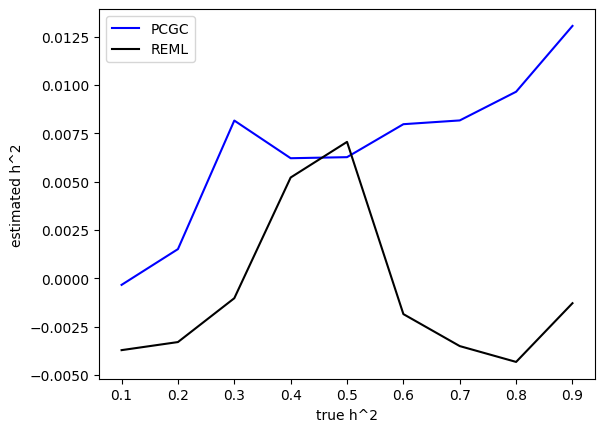

In [3]:
import matplotlib.pyplot as plt

reml_means = []
pcgc_means = []
true_sq_sigma_g = np.linspace(.1, .9, 9)
for sq_sigma_g in true_sq_sigma_g:
    reml_est, pcgc_est = estimate(1000, 400, sq_sigma_g, .01, .05)
    reml_means.append(reml_est.mean())
    pcgc_means.append(pcgc_est.mean())

plt.plot(true_sq_sigma_g, pcgc_means, 'b', label='PCGC')
plt.plot(true_sq_sigma_g, reml_means, 'k', label='REML')
plt.xlabel("true h^2")
plt.ylabel("estimated h^2")
plt.legend()
plt.show()

The absolute value of the estimates still need calibration at the moment, but we can also witness the downwards bias of REML compared to PCGC.